In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.optimize import minimize


class KernelSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, kernel='linear', gamma=None, degree=3):
        self.C = C  # regularization parameter
        self.kernel = kernel  # kernel type
        self.gamma = gamma  # kernel coefficient for 'rbf', 'poly', and 'sigmoid'
        self.degree = degree  # degree of the polynomial kernel

        self.alpha = None  # dual coefficients
        self.support_vectors = None  # support vectors
        self.intercept = None  # intercept term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute kernel matrix
        K = pairwise_kernels(X, metric=self.kernel, gamma=self.gamma, degree=self.degree)

        # Define the objective function for optimization
        def objective(alpha):
            return 0.5 * np.dot(alpha, np.dot(alpha, K)) - np.sum(alpha)

        # Define the equality constraint
        def zerofun(alpha):
            return np.dot(alpha, y)

        # Define bounds for alpha values
        bounds = [(0, self.C) for _ in range(n_samples)]

        # Solve the optimization problem
        initial_guess = np.random.random(n_samples)
        constraints = [{'type': 'eq', 'fun': zerofun}]
        solution = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
        self.alpha = solution.x

        # Select support vectors (non-zero alphas)
        support_vector_indices = np.where(self.alpha > 1e-5)[0]
        self.support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]
        support_vector_alphas = self.alpha[support_vector_indices]

        # Compute the intercept term
        self.intercept = np.mean(support_vector_labels - np.dot(support_vector_alphas * support_vector_labels,
                                                                 pairwise_kernels(self.support_vectors, X,
                                                                                  metric=self.kernel,
                                                                                  gamma=self.gamma,
                                                                                  degree=self.degree)))

    def predict(self, X):
        # Compute kernel matrix between support vectors and test samples
        K = pairwise_kernels(X, self.support_vectors, metric=self.kernel, gamma=self.gamma, degree=self.degree)

        # Compute decision function
        decision = np.dot(self.alpha * self.support_vectors, K.T) - self.intercept

        # Predict the labels based on the sign of the decision function
        y_pred = np.sign(decision)
        return y_pred


In [5]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [11]:
X,y = make_circles(n_samples=100,random_state=42,noise=.01)

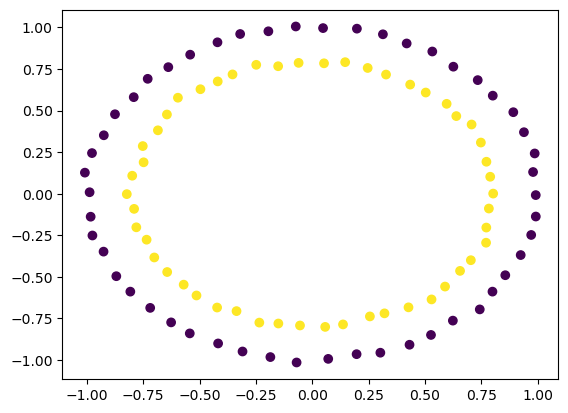

In [14]:
plt.scatter(X[:,0],X[:,1],c=y)

In [47]:
from sklearn.svm import SVC
model = SVC(kernel='poly',degree=2)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [50]:
model.fit(X_train,y_train)

SVC(degree=2, kernel='poly')

In [51]:
model.score(X_test,y_test)

1.0